In [1]:
from typing import List, NamedTuple, Optional, Tuple, Generator

import numpy as np
from matplotlib import pyplot as plt
from skimage.draw import circle_perimeter_aa

import torch as t
import torch.nn.functional as F
import torch.nn as nn

from functools import reduce

import datetime
import uuid

In [2]:
device = 'cuda' if t.cuda.is_available() else 'mps'
t.set_default_device(device)

In [3]:
import uuid
session_id = str(uuid.uuid4())[:8] # Session id used to identify training session in saved checkpoint

In [4]:
class CircleParams(NamedTuple):
    row: int
    col: int
    radius: int

def draw_circle(img: np.ndarray, row: int, col: int, radius: int) -> np.ndarray:
    """
    Draw a circle in a numpy array, inplace.
    The center of the circle is at (row, col) and the radius is given by radius.
    The array is assumed to be square.
    Any pixels outside the array are ignored.
    Circle is white (1) on black (0) background, and is anti-aliased.
    """
    rr, cc, val = circle_perimeter_aa(row, col, radius)
    valid = (rr >= 0) & (rr < img.shape[0]) & (cc >= 0) & (cc < img.shape[1])
    img[rr[valid], cc[valid]] = val[valid]
    return img


def noisy_circle(
        img_size: int, min_radius: float, max_radius: float, noise_level: float
) -> Tuple[np.ndarray, CircleParams]:
    """
    Draw a circle in a numpy array, with normal noise.
    """

    # Create an empty image
    img = np.zeros((img_size, img_size))

    radius = np.random.randint(min_radius, max_radius)

    # x,y coordinates of the center of the circle
    row, col = np.random.randint(img_size, size=2)

    # Draw the circle inplace
    draw_circle(img, row, col, radius)

    added_noise = np.random.normal(0.5, noise_level, img.shape)
    img += added_noise

    return img, CircleParams(row, col, radius)


def show_circle(img: np.ndarray):
    fig, ax = plt.subplots()
    ax.imshow(img, cmap='gray')
    ax.set_title('Circle')
    plt.show()

def generate_examples(
        noise_level: float = 0.5,
        img_size: int = 100,
        min_radius: Optional[int] = None,
        max_radius: Optional[int] = None,
        dataset_path: str = 'ds',
) -> Generator[Tuple[np.ndarray, CircleParams], None, None]:
    if not min_radius:
        min_radius = img_size // 10
    if not max_radius:
        max_radius = img_size // 2
    assert max_radius > min_radius, "max_radius must be greater than min_radius"
    assert img_size > max_radius, "size should be greater than max_radius"
    assert noise_level >= 0, "noise should be non-negative"

    params = f"{noise_level=}, {img_size=}, {min_radius=}, {max_radius=}, {dataset_path=}"
    print(f"Using parameters: {params}")
    while True:
        img, params = noisy_circle(
            img_size=img_size, min_radius=min_radius, max_radius=max_radius, noise_level=noise_level
        )
        yield img, params

The intersection over union function is modified, substituting in torch's numpy substitutes, allowing for autograd to record the computation graph through the IOU function.


In [5]:
def iou_circle_gradient_friendly(a: t.Tensor, b: t.Tensor) -> t.Tensor:
    """
        Gradient friendly calculation of intersection over union of an input tensor where
        each entry in the tensor is as follows:
            - The X coordinate of the center of the circle
            - The Y coordinate of the center of the circle
            - The radius of the circle
    """
    distance_between_centers = t.linalg.norm(a[0:2] - b[0:2])
    iou = t.tensor(0, dtype=t.float, requires_grad=True)

    r1, r2 = a[2], b[2]

    if distance_between_centers > r1 + r2:
        # If the distance between the centers is greater than the sum of the radii, then the circles don't intersect
        return iou
    if distance_between_centers <= abs(r1 - r2):
        # If the distance between the centers is less than the absolute difference of the radii, then one circle is 
        # inside the other
        larger_r, smaller_r = t.max(r1, r2), t.min(r1, r2)
        iou = smaller_r ** 2 / larger_r ** 2
        return iou

    r1_sq, r2_sq = r1**2, r2**2
    d1 = (r1_sq - r2_sq + distance_between_centers**2) / (2 * distance_between_centers)
    d2 = distance_between_centers - d1
    sector_area1 = r1_sq * t.arccos(d1 / r1)
    triangle_area1 = d1 * t.sqrt(r1_sq - d1**2)
    sector_area2 = r2_sq * t.arccos(d2 / r2)
    triangle_area2 = d2 * t.sqrt(r2_sq - d2**2)
    intersection = sector_area1 + sector_area2 - (triangle_area1 + triangle_area2)
    union = np.pi * (r1_sq + r2_sq) - intersection
    return intersection / union

To calculate loss, the average IOU error is used, rather than a threshold IOU. This choice was made after testing threshold IOU and finding it difficult to initially converge.


In [6]:
def calculate_average_iou_error(pred: List[t.Tensor], params: List[t.tensor]) -> t.Tensor:
        """
            Calculates the average error over the predicted and actual IOU (1 - average IOU)
        """
        ious = t.empty(size=(len(params),))
        for i in range(len(params)):
            calculated_iou = iou_circle_gradient_friendly(pred[i], params[i])
            ious[i] = calculated_iou

        return 1 - (ious.sum() / len(params))

We define a basic CNN with 2 convolutional layers, and linear-layers to reduce the output to a tensor with 3 elements, representing regressive outputs for the 3 parameters being predicted:

1. The circle's center x-coordinate
2. The circle's center y-coordinate
3. The circle's radius


In [7]:
class CircleCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=512, kernel_size=48, stride=1, padding=0)
        self.conv2 = nn.Conv2d(in_channels=512, out_channels=128, kernel_size=8, stride=3, padding=0)
        self.fc1 = nn.Linear(8192, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 3)

        self.bn1 = nn.BatchNorm2d(512)
        self.bn2 = nn.BatchNorm2d(128)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.relu(x)

        x = self.conv2(x)
        x = F.max_pool2d(x, kernel_size=2, stride=2)
        x = self.bn2(x)

        x = t.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        return x

The model is initialized and trained for 16384 epochs with a batch-size of 128 on newly-generated test-data on every iteration. The standard go-to Adam optimizer with a learning rate of 1e-3 is used to optimize the model. Conveniently being able to generate newly-seen train-data on every epoch takes overfitting out of consideration during the model training phase.


In [8]:
num_epochs = 16384
batch_size = 128
circle_generator = generate_examples()
model = CircleCNN()
optimizer = t.optim.Adam(model.parameters(), lr=1e-3)

The model contains 7506563 parameters.


In [9]:
num_parameters = sum([reduce(lambda a, b: a*b, x.shape) for x in list(model.parameters())])
print(num_parameters)

7506563


In [2]:
def train():
    for epoch in range(num_epochs):
        imgs = []
        params = []

        # Build a batch of training images and parameters
        for i in range(batch_size):
            img, param = circle_generator.__next__()
            img = t.from_numpy(img).to(t.float)
            imgs.append(img)
            params.append([param.row, param.col, param.radius])

        # Convert the list of images to a (B,1,100,100) tensor representing (B,C,100,100)
        imgs = t.stack(imgs)
        imgs = imgs.reshape(batch_size,1,100,100)
        imgs = imgs.to(device=device, dtype=t.float)

        # Convert the list of parameters to a tensor
        params = t.Tensor(params)
        params = params.to(device=device, dtype=t.float)

        # Do the forward pass through the model
        y_pred = model.forward(imgs)

        # Calculate the error
        loss = calculate_average_iou_error(y_pred, params)

        # Do the backward pass
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        # Save the model as a check-point afer every 64-epochs
        if (epoch + 1) % 64 == 0:
            t.save({
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': loss,
                'epoch': epoch
            }, f'./checkpoints/{datetime.date.today()}-{session_id}-epoch-{epoch + 1}')

        print(f"[Epoch {epoch + 1:03d}/{num_epochs:03d}] Train loss: {loss:>16.10f}")
        
# train()

Using parameters: noise_level=0.5, img_size=100, min_radius=10, max_radius=50, dataset_path='ds'
[Epoch 001/16384] Train loss:     0.9999997020
[Epoch 002/16384] Train loss:     0.9999957085
[Epoch 003/16384] Train loss:     0.9999946356
[Epoch 004/16384] Train loss:     0.9999579787
[Epoch 005/16384] Train loss:     0.9999344945
[Epoch 006/16384] Train loss:     0.9996381402
[Epoch 007/16384] Train loss:     0.9996361136
[Epoch 008/16384] Train loss:     0.9948534966
[Epoch 009/16384] Train loss:     0.9924270511
[Epoch 010/16384] Train loss:     0.9563639760
[Epoch 011/16384] Train loss:     0.9690209627
[Epoch 012/16384] Train loss:     0.9676033258
[Epoch 013/16384] Train loss:     0.9383860826
[Epoch 014/16384] Train loss:     0.9230237007
[Epoch 015/16384] Train loss:     0.9329608679
[Epoch 016/16384] Train loss:     0.9123730659
[Epoch 017/16384] Train loss:     0.9367268682
[Epoch 018/16384] Train loss:     0.9174172878
[Epoch 019/16384] Train loss:     0.9054943323
[Epoch 020

After 3-hours of training, the model converges to a loss of ~0.08, meaning an average IOU of > 0.92!


To test out the model, we can run inference on some noisy images, and highlight the predicted and actual circles.


In [ ]:
model_path = './checkpoints/2024-01-04-f5286572-epoch-16384'
loaded_model = t.load(model_path)
loaded_state_dict = loaded_model['model_state_dict']
model.load_state_dict(loaded_state_dict) # Fine-tuning

In [12]:
def convert_channel_to_rgb_scale(img: np.ndarray):
    """
        Converts a grayscale image of arbitrary range to one in the RGB range 0-1
    """
    rgb_image = np.copy(img)
    min = np.amin(img)
    rgb_image -= min
    rgb_image = rgb_image / np.amax(rgb_image)
    return rgb_image

In [13]:
def draw_highlighted_circles(img: np.ndarray, actual_circle: t.Tensor, predicted_circle: t.Tensor) -> np.ndarray:
    """
        Draws the actual circle in green and the predicted
        circle in red atop the noisy image.

        Returns a new numpy array of size (3, 100, 100)
        with values floating-point values representing the image
    """
    
    # Convert the noisy-image to an RGB one with floats ranging from 0-1
    converted_rgb_channel = convert_channel_to_rgb_scale(img)
    # Convert the (100, 100) image to a (100, 100, 3) image
    converted_img = np.dstack([converted_rgb_channel, converted_rgb_channel, converted_rgb_channel])

    (a_row, a_col, a_radius) = actual_circle
    (p_row, p_col, p_radius) = predicted_circle

    # Get channels for the actual and predicted circles drawn
    act_red_channel = draw_circle(np.zeros_like(img), int(a_row), int(a_col), int(a_radius))
    pred_green_channel = draw_circle(np.zeros_like(img), int(p_row), int(p_col), int(p_radius))

    # Replace RGB values in the noisy-image with RGB values from the drawn circles
    pred_replacement_values = pred_green_channel[pred_green_channel > 0]
    fill_values = np.zeros_like(pred_replacement_values)
    converted_img[pred_green_channel > 0] = np.dstack([pred_replacement_values, fill_values, fill_values])

    act_replacement_values = act_red_channel[act_red_channel > 0]
    fill_values = np.zeros_like(act_replacement_values)
    converted_img[act_red_channel > 0] = np.dstack([fill_values, act_replacement_values, fill_values])

    return converted_img

In [14]:
def show_original_versus_prediction(img: np.ndarray, actual_circle: t.Tensor, predicted_circle: t.Tensor):
    """
        Shows the original vs predicted circle graphed side by side
    """
    highlighted_circles = draw_highlighted_circles(img, actual_circle, predicted_circle)

    fig, (ax1, ax2) = plt.subplots(1, 2)

    ax1.set_title("Original Noisy Image")
    ax2.set_title("Predicted Circle")

    ax1.imshow(img, cmap='gray')
    ax2.imshow(highlighted_circles)

    plt.show()

In [15]:
def run_inference():
    # Generate a noisy circle
    img, param = circle_generator.__next__()
    numpy_img = img

    # Convert the image to a tensor and reshape it for inference, adding a channel and batch dimension
    img = t.tensor(img, device='cuda', dtype=t.float)
    img = img.reshape(1,1,100,100)

    # Convert the parameters to a tensor
    param = t.tensor(param, device='cuda', dtype=t.float)

    # Run the forward pass
    y_pred = model.forward(img)

    # Calculate the IOU
    y_pred.squeeze_(0) # Remove the batch dimension from the prediction
    predicted_iou = iou_circle_gradient_friendly(param, y_pred)

    (pred_row, pred_col, pred_radius) = y_pred
    (act_row, act_col, act_radius) = param

    print(f'Predicted Parameters: row={pred_row:<8.2f} col={pred_col:<8.2f} radius={pred_radius:<8.2f}')
    print(f'Actual Parameters:    row={act_row:<8.2f} col={act_col:<8.2f} radius={act_radius:<8.2f}')
    print(f'IOU: {predicted_iou}')

    # Show the original image and the prediction
    show_original_versus_prediction(numpy_img, param, y_pred)

Predicted Parameters: row=44.30    col=37.87    radius=25.00   
Actual Parameters:    row=42.00    col=36.00    radius=25.00   
IOU: 0.8597134947776794


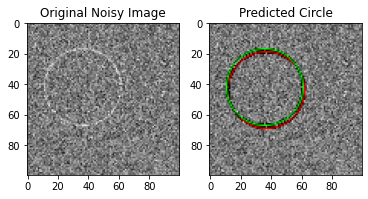

Predicted Parameters: row=76.07    col=48.05    radius=21.62   
Actual Parameters:    row=81.00    col=44.00    radius=15.00   
IOU: 0.48151856660842896


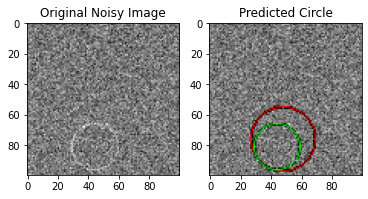

Predicted Parameters: row=40.17    col=19.47    radius=31.79   
Actual Parameters:    row=40.00    col=19.00    radius=31.00   
IOU: 0.9509829878807068


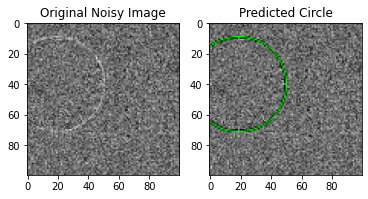

Predicted Parameters: row=41.32    col=84.40    radius=39.31   
Actual Parameters:    row=43.00    col=87.00    radius=41.00   
IOU: 0.892956018447876


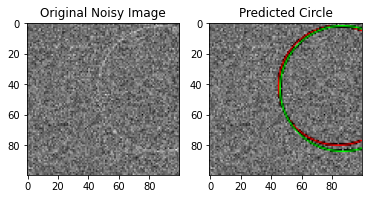

Predicted Parameters: row=43.13    col=94.73    radius=39.64   
Actual Parameters:    row=44.00    col=98.00    radius=42.00   
IOU: 0.875950813293457


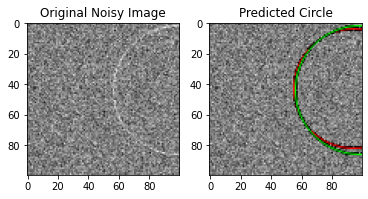

Predicted Parameters: row=65.11    col=42.53    radius=35.41   
Actual Parameters:    row=66.00    col=40.00    radius=37.00   
IOU: 0.8944234848022461


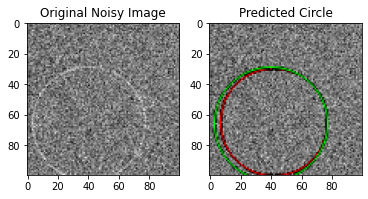

Predicted Parameters: row=81.21    col=62.70    radius=34.02   
Actual Parameters:    row=84.00    col=66.00    radius=36.00   
IOU: 0.840255618095398


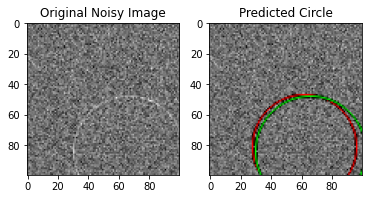

Predicted Parameters: row=49.28    col=81.93    radius=31.74   
Actual Parameters:    row=52.00    col=83.00    radius=33.00   
IOU: 0.8816741108894348


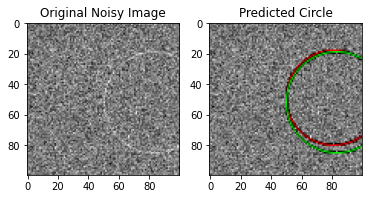

In [17]:
num_examples = 8

for _ in range(num_examples):
    run_inference()

As seen in the test examples above, the model does well identifying circles in the noisy images, consistently achieving IOU.
